In [1]:
# %pip install tonic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.7/109.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.7/253.7 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 12.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.1/390.1 kB 9.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.1/232.1 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 10.8 MB/s eta 0:00:0000:0100:01
  Created wheel for expelliarmus: filename=expelliarmus-1.1.12-cp39-cp39-macosx_11_0_arm64.whl size=25747 sha256=e434dca48b075aa85278a56630e4a6d3aef593b78165dfadcdf5ae3028028310
  Stored in directory: 

In [2]:
# %pip install snntorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 5.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tonic
from tonic import DiskCachedDataset
import tonic.transforms as transforms
import torch
from torch.utils.data import DataLoader
import numpy as np
from sklearn import linear_model
import time
import lsm_weight_definitions as lsm_wts
import lsm_models

/home/umic/anaconda3/envs/ML/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if __name__ == "__main__":

    #Load dataset (Using NMNIST here)
    sensor_size = tonic.datasets.NMNIST.sensor_size
    frame_transform = transforms.Compose([transforms.Denoise(filter_time=3000),
                                          transforms.ToFrame(sensor_size=sensor_size,time_window=1000)])

    trainset = tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=True)
    testset = tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=False)

    cached_trainset = DiskCachedDataset(trainset, cache_path='./cache/nmnist/train')
    cached_testset = DiskCachedDataset(testset, cache_path='./cache/nmnist/test')

    batch_size = 300
    trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)
    testloader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False))

    #Set device
    #device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
    device = torch.device("cpu") if torch.cuda.is_available() else torch.device("cpu")
    print(device) 

    data, targets = next(iter(trainloader))
    flat_data = torch.reshape(data, (data.shape[0], data.shape[1], -1))
    print(flat_data.shape)

    in_sz = flat_data.shape[-1]

    #Set neuron parameters
    tauV = 15.0
    tauI = 15.0
    th = 18
    curr_prefac = np.float32(1/tauI)
    alpha = np.float32(np.exp(-1/tauI))
    beta = np.float32(1 - 1/tauV)

    Win1, Wlsm1 = lsm_wts.initWeights1(25, 1.5, 0.13, in_sz)
    N1 = Wlsm1.shape[0]
    lsm_net1 = lsm_models.LSM(N1, in_sz, np.float32(curr_prefac*Win1), np.float32(curr_prefac*Wlsm1), alpha=alpha, beta=beta, th=th).to(device)
    lsm_net1.eval()
    Win2, Wlsm2 = lsm_wts.initWeights1(23, 1.1, 0.1, 1000)
    N2 = Wlsm2.shape[0]
    lsm_net2 = lsm_models.LSM(N2, in_sz, np.float32(curr_prefac*Win2), np.float32(curr_prefac*Wlsm2), alpha=alpha, beta=beta, th=th).to(device)
    lsm_net2.eval()
    Win3, Wlsm3 = lsm_wts.initWeights1(27, 1.6, 0.15, 1000)
    N3 = Wlsm3.shape[0]
    lsm_net3 = lsm_models.LSM(N3, in_sz, np.float32(curr_prefac*Win3), np.float32(curr_prefac*Wlsm3), alpha=alpha, beta=beta, th=th).to(device)
    lsm_net3.eval()
    Win4, Wlsm4 = lsm_wts.initWeights1(26.3, 1.4, 0.136, 1000)
    N4 = Wlsm4.shape[0]
    lsm_net4 = lsm_models.LSM(N4, in_sz, np.float32(curr_prefac*Win4), np.float32(curr_prefac*Wlsm4), alpha=alpha, beta=beta, th=th).to(device)
    lsm_net4.eval()
    Win5, Wlsm5 = lsm_wts.initWeights1(28, 1.57, 0.139, 1000)
    N5 = Wlsm5.shape[0]
    lsm_net5 = lsm_models.LSM(N5, in_sz, np.float32(curr_prefac*Win5), np.float32(curr_prefac*Wlsm5), alpha=alpha, beta=beta, th=th).to(device)
    lsm_net5.eval()
    #Run with no_grad for LSM
    with torch.no_grad():
        start_time = time.time()
        for i, (data, targets) in enumerate(iter(trainloader)):
            if i%25 == 24:
                print("train batches completed: ", i)
            flat_data = torch.reshape(data, (data.shape[0], data.shape[1], -1)).to(device)
            spk_rec1 = lsm_net1(flat_data)
            spk_rec2 = lsm_net2(spk_rec1)
            spk_rec3 = lsm_net3(spk_rec2)
            spk_rec4 = lsm_net4(spk_rec3)
            spk_rec5 = lsm_net5(spk_rec4)
            # print(spk_rec5.shape)
            lsm_out1 = torch.mean(spk_rec1, dim=0)
            lsm_out2 = torch.mean(spk_rec2, dim=0)
            lsm_out3 = torch.mean(spk_rec3, dim=0)
            lsm_out4 = torch.mean(spk_rec4, dim=0)
            lsm_out5 = torch.mean(spk_rec5, dim=0)
            if i==0:
                in_train = torch.mean(flat_data, dim=0).cpu().numpy()
                lsm_out_train1 = lsm_out1.cpu().numpy()
                lsm_out_train2 = lsm_out2.cpu().numpy()
                lsm_out_train3 = lsm_out3.cpu().numpy()
                lsm_out_train4 = lsm_out4.cpu().numpy()
                lsm_out_train5 = lsm_out5.cpu().numpy()
                lsm_label_train = np.int32(targets.numpy())
            else:
                in_train = np.concatenate((in_train, torch.mean(flat_data, dim=0).cpu().numpy()), axis=0)
                lsm_out_train1 = np.concatenate((lsm_out_train1, lsm_out1.cpu().numpy()), axis=0)
                lsm_out_train2 = np.concatenate((lsm_out_train2, lsm_out2.cpu().numpy()), axis=0)
                lsm_out_train3 = np.concatenate((lsm_out_train3, lsm_out3.cpu().numpy()), axis=0)
                lsm_out_train4 = np.concatenate((lsm_out_train4, lsm_out4.cpu().numpy()), axis=0)
                lsm_out_train5 = np.concatenate((lsm_out_train5, lsm_out5.cpu().numpy()), axis=0)
                lsm_label_train = np.concatenate((lsm_label_train, np.int32(targets.numpy())), axis=0)
        end_time = time.time()

        print("running time of training epoch: ", end_time - start_time, "seconds")

        for i, (data, targets) in enumerate(iter(testloader)):
            if i%25 == 24:
                print("test batches completed: ", i)
            flat_data = torch.reshape(data, (data.shape[0], data.shape[1], -1)).to(device)
            lsm_net1.eval()
            lsm_net2.eval()
            lsm_net3.eval()
            lsm_net4.eval()
            lsm_net5.eval()
            spk_rec1 = lsm_net1(flat_data)
            spk_rec2 = lsm_net2(spk_rec1)
            spk_rec3 = lsm_net3(spk_rec2)
            spk_rec4 = lsm_net4(spk_rec3)
            spk_rec5 = lsm_net5(spk_rec4)
            lsm_out1 = torch.mean(spk_rec1, dim=0)
            lsm_out2 = torch.mean(spk_rec2, dim=0)
            lsm_out3 = torch.mean(spk_rec3, dim=0)
            lsm_out4 = torch.mean(spk_rec4, dim=0)
            lsm_out5 = torch.mean(spk_rec5, dim=0)
            if i==0:
                in_test = torch.mean(flat_data, dim=0).cpu().numpy()
                lsm_out_test1 = lsm_out1.cpu().numpy()
                lsm_out_test2 = lsm_out2.cpu().numpy()
                lsm_out_test3 = lsm_out3.cpu().numpy()
                lsm_out_test4 = lsm_out4.cpu().numpy()
                lsm_out_test5 = lsm_out5.cpu().numpy()
                lsm_label_test = np.int32(targets.numpy())
            else:
                in_test = np.concatenate((in_test, torch.mean(flat_data, dim=0).cpu().numpy()), axis=0)
                lsm_out_test1 = np.concatenate((lsm_out_test1, lsm_out1.cpu().numpy()), axis=0)
                lsm_out_test2 = np.concatenate((lsm_out_test2, lsm_out2.cpu().numpy()), axis=0)
                lsm_out_test3 = np.concatenate((lsm_out_test3, lsm_out3.cpu().numpy()), axis=0)
                lsm_out_test4 = np.concatenate((lsm_out_test4, lsm_out4.cpu().numpy()), axis=0)
                lsm_out_test5 = np.concatenate((lsm_out_test5, lsm_out5.cpu().numpy()), axis=0)
                lsm_label_test = np.concatenate((lsm_label_test, np.int32(targets.numpy())), axis=0)

    print(lsm_out_train1.shape)
    print(lsm_out_test1.shape)

    print(in_train.shape)
    print(in_test.shape)

    print("mean in spiking (train) : ", np.mean(in_train))
    print("mean in spiking (test) : ", np.mean(in_test))

    print("mean LSM spiking (train) : ", np.mean(lsm_out_train1))
    print("mean LSM spiking (test) : ", np.mean(lsm_out_test1))

    print("training linear model:")
    clf1 = linear_model.SGDClassifier(max_iter=10000, tol=1e-6)
    clf1.fit(lsm_out_train1, lsm_label_train)
    clf2 = linear_model.SGDClassifier(max_iter=10000, tol=1e-6)
    clf2.fit(lsm_out_train2, lsm_label_train)
    clf3 = linear_model.SGDClassifier(max_iter=10000, tol=1e-6)
    clf3.fit(lsm_out_train3, lsm_label_train)
    clf4 = linear_model.SGDClassifier(max_iter=10000, tol=1e-6)
    clf4.fit(lsm_out_train4, lsm_label_train)
    clf5 = linear_model.SGDClassifier(max_iter=10000, tol=1e-6)
    clf5.fit(lsm_out_train5, lsm_label_train)
    score1 = clf1.score(lsm_out_test1, lsm_label_test)
    score2 = clf2.score(lsm_out_test2, lsm_label_test)
    score3 = clf3.score(lsm_out_test3, lsm_label_test)
    score4 = clf4.score(lsm_out_test4, lsm_label_test)
    score5 = clf5.score(lsm_out_test5, lsm_label_test)
    print("test score = " + str(score1))
    arr = [score1, score2, score3, score4, score5]

cpu
torch.Size([311, 300, 2312])
train batches completed:  24
train batches completed:  49
train batches completed:  74
train batches completed:  99
train batches completed:  124
train batches completed:  149
train batches completed:  174
train batches completed:  199
running time of training epoch:  692.963725566864 seconds
test batches completed:  24
(60000, 1000)
(10000, 1000)
(60000, 2312)
(10000, 2312)
mean in spiking (train) :  0.0045132656
mean in spiking (test) :  0.0045407712
mean LSM spiking (train) :  0.16520076
mean LSM spiking (test) :  0.16858093
training linear model:
test score = 0.957


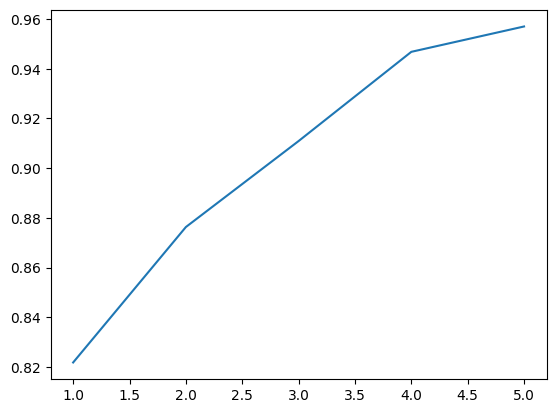

In [4]:
import matplotlib.pyplot as plt
x = [1,2,3,4,5]
plt.plot(x, arr[-1::-1])